# Cloud organization recognition

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install -q albumentations==0.3.3

     |████████████████████████████████| 92kB 4.4MB/s 
     |████████████████████████████████| 634kB 15.2MB/s 
     |████████████████████████████████| 28.7MB 1.2MB/s 


In [0]:
import os, time, json, re, copy
import itertools, argparse, pickle, random

import numpy as np
import pandas as pd
from PIL import Image
import cv2

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import models
import torchvision.transforms as T

import albumentations as albu
from albumentations import pytorch as AT

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [0]:
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapOnImage

In [0]:
path = '/content/'

## Download the data

In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [11]:
!kaggle competitions download -c understanding_cloud_organization -f train.csv
!unzip train.csv.zip
!rm train.csv.zip

 89% 48.0M/54.2M [00:00<00:00, 42.8MB/s]
100% 54.2M/54.2M [00:00<00:00, 85.2MB/s]
Archive:  train.csv.zip
  inflating: train.csv               


In [12]:
!kaggle datasets download -d ryches/understanding-clouds-resized
!unzip -q understanding-clouds-resized.zip
!rm understanding-clouds-resized.zip

 98% 985M/0.98G [00:19<00:00, 47.3MB/s]
100% 0.98G/0.98G [00:19<00:00, 53.0MB/s]


In [13]:
len(os.listdir('train_images_525/train_images_525')), len(os.listdir('test_images_525/test_images_525'))

(5546, 3698)

In [0]:
if not os.path.exists(path+'train'): os.mkdir(path+'train')
if not os.path.exists(path+'test'): os.mkdir(path+'test')

In [0]:
!kaggle competitions download -c understanding_cloud_organization -f train_images.zip
!unzip train_images.zip -d train

In [0]:
!kaggle competitions download -c understanding_cloud_organization -f test_images.zip
!unzip test_images.zip -d test

In [0]:
!rm train_images.zip test_images.zip

In [0]:
len(os.listdir('train')), len(os.listdir('test'))

(5546, 3698)

## Looking at the data

In [15]:
df = pd.read_csv('train.csv')
df.head()

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...

In [0]:
def code_to_mask(code, width, height):
    if code == -1:
        return np.zeros((height, width), dtype=np.uint8)
    
    mask = np.zeros(height*width, dtype=np.uint8)
    code = [int(c) for c in code.split()]
    code = [(code[i], code[i+1]) for i in range(len(code)) if i%2==0]
    for c in code:
        start = c[0]-1
        end = start+c[1]
        mask[start:end] = 255
    mask = mask.reshape(width, height)
    return mask.T

def plot_images_mask(im, mask, figsize=(14,7)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)

    ax[0].axis('off')
    ax[0].imshow(im)

    ax[1].axis('off')
    ax[1].imshow(im)
    ax[1].imshow(mask, cmap='Reds', alpha=0.15)

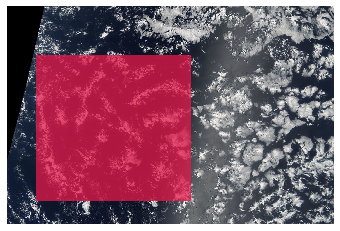

In [0]:
im = Image.open(path+'train/'+df['Image_Label'][0].split('_')[0])
label_pixels = df['EncodedPixels'][0]
mask = code_to_mask(label_pixels, *(im.size))

segmap = SegmentationMapOnImage(mask.clip(0,1), mask.shape, nb_classes=2)

plt.axis('off')
plt.imshow(segmap.draw_on_image(np.array(im)));

In [0]:
for k in df['EncodedPixels'][~df['EncodedPixels'].isnull()].index[:6]:
    im = Image.open(path+'train/'+df['Image_Label'][k].split('_')[0])
    label_pixels = df['EncodedPixels'][k]
    mask = code_to_mask(label_pixels, *(im.size))

    plot_images_mask(im, mask)

Output hidden; open in https://colab.research.google.com to view.

## Albumentation

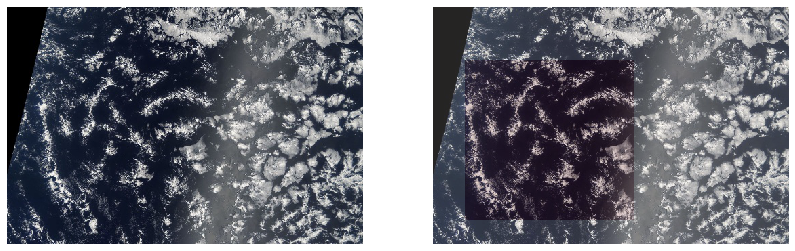

In [16]:
im_name = df['Image_Label'][0].split('_')[0]
im = Image.open(path+'train_images_525/train_images_525/'+im_name)
mask = Image.open(path+'train_masks_525/train_masks_525/Fish'+im_name)

im_tensor = torch.from_numpy(np.array(im))
mask_tensor = torch.from_numpy(np.array(mask))

plot_images_mask(im, mask)

horizontal flip

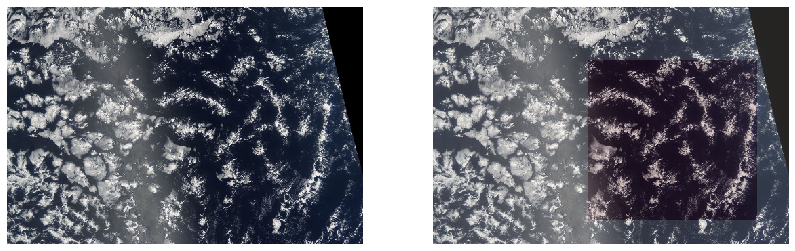

In [17]:
tsfm = albu.HorizontalFlip(p=1)
im_aug = tsfm(image=np.array(im))
mask_aug = tsfm(image=np.array(mask))

plot_images_mask(im_aug['image'], mask_aug['image'])

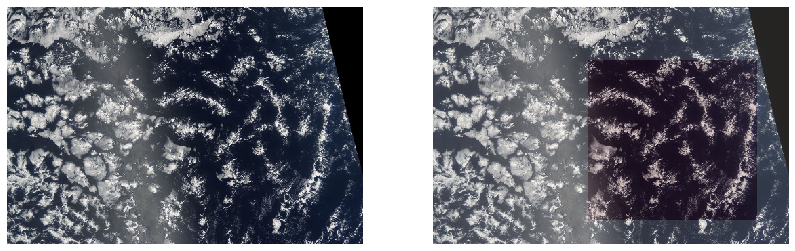

In [27]:
# directly from tensor
plot_images_mask(im_tensor.flip(1).numpy(), mask_tensor.flip(1).numpy())

vertical flip

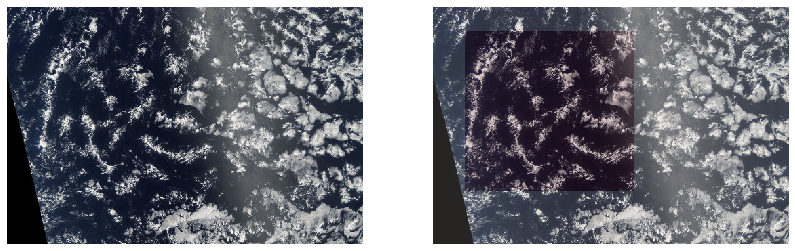

In [0]:
tsfm = albu.VerticalFlip(p=1)
im_aug = tsfm(image=np.array(im))
mask_aug = tsfm(image=np.array(mask))

plot_images_mask(im_aug['image'], mask_aug['image'])

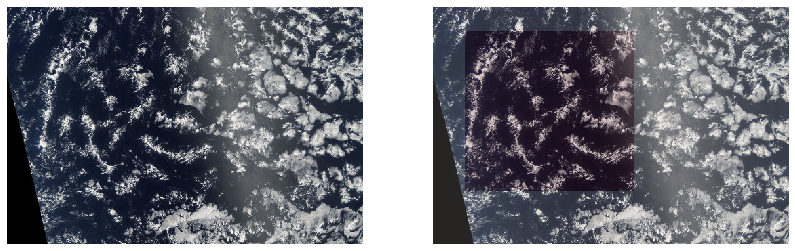

In [28]:
# directly from tensor
plot_images_mask(im_tensor.flip(0).numpy(), mask_tensor.flip(0).numpy())

90s rotation

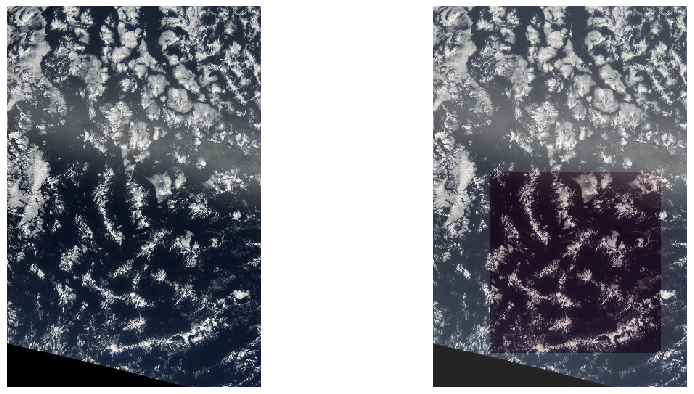

In [0]:
tsfm = albu.RandomRotate90(p=1)
aug = tsfm(image=np.array(im), mask=np.array(mask))

plot_images_mask(aug['image'], aug['mask'])

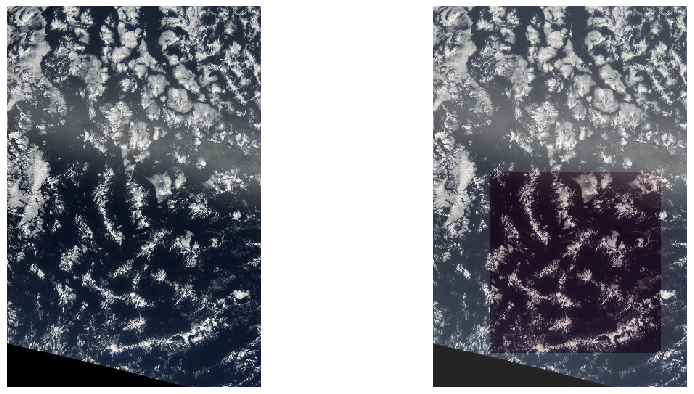

In [29]:
# directly from tensor
plot_images_mask(torch.rot90(im_tensor, 1, [0,1]).numpy(), torch.rot90(mask_tensor, 1, [0,1]).numpy())

elastic transformation

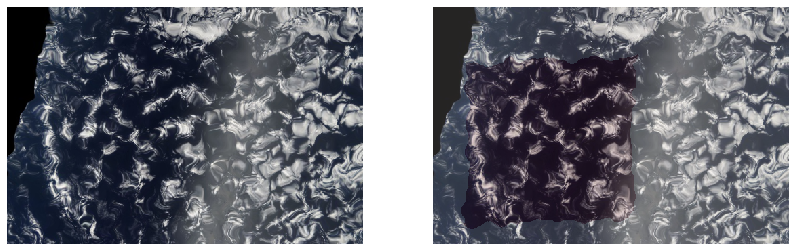

In [0]:
tsfm = albu.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
aug = tsfm(image=np.array(im), mask=np.array(mask))

plot_images_mask(aug['image'], aug['mask'])